In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
w = cluster.start_workers(17)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.13:47068 Dashboard: http://10.148.1.13:8787/status,Cluster Workers: 34 Cores: 136 Memory: 1700.00 GB


---


# 1. Data files
#### faces in range of 60ºS ~ 60ºN : 1, 2, 4, 5, 7, 8, 10, 11
#### other faces (polar regions): 0, 3, 6, 9, 12

In [10]:
v_u = 'SSU'
v_v = 'SSV'

## data files (SSU,SSV) ##
data_dir = '/home1/scratch/xyu/mit_zarr/UV/LLC4320/'

## dir where spectra will be stored
E_dir = '/home1/datawork/xyu/LLC4320/mit_zavg_spec/zavg_UV/linear_window/'

print(data_dir)
print(E_dir)

/home1/scratch/xyu/mit_zarr/UV/LLC4320/
/home1/datawork/xyu/LLC4320/mit_zavg_spec/zavg_UV/linear_window/


## Grid

In [7]:
# grid file
mgrid = xr.open_dataset('/home1/datawork/xyu/grid/mit_grid_t.nc')
mgrid = mgrid.drop(['XG','YG','i_g','j_g','dxG','dyG','dxC','dyC','rAw','rAs','rAz'])
print(mgrid)

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, j: 4320)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, i, j) float32 ...
    YC       (face, i, j) float32 ...
    CS       (face, i, j) float32 ...
    SN       (face, i, j) float32 ...
    rA       (face, i, j) float32 ...
    Depth    (face, i, j) float32 ...
Data variables:
    *empty*
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...


_________
# 2. FFT

In [9]:
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

## Here we do DFT on u+iv ##
time_chunk = 1440
ij_chunk = 108

for face in face_all:
    
    # Grid #
    grid = mgrid.isel(face=face)
    
    # Read SSU #
    ds_SSU = xr.open_zarr(data_dir+'SSU_f%02d.zarr'%(face)).rename({'i_g': 'i'})
    chunks={'time': time_chunk, 'i': ij_chunk, 'j': ij_chunk} # time chunck: (2 months)
    ds_SSU = ds_SSU.chunk(chunks) 
    # Read SSV #
    ds_SSV = xr.open_zarr(data_dir+'SSV_f%02d.zarr'%(face)).rename({'j_g': 'j'})
    chunks={'time': time_chunk, 'i': ij_chunk, 'j': ij_chunk} # time chunck: (2 months)
    ds_SSV = ds_SSV.chunk(chunks) 
    # Merge into one xarray dataset #
    ds = xr.merge([ds_SSU, ds_SSV, grid])    

    
    # u+iv
    uv_complex = (ds_SSU['SSU'] + 1j*ds_SSV['SSV'])
    # fft
    uv_fft_complex = xrft.dft(uv_complex.fillna(0.), dim=['time'], shift=False, detrend='linear', window=True, chunks_to_segments=True)    
    E_uv_segments = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/time_chunk*3600        
    E_uv = E_uv_segments.mean(dim=['time_segment']) 
    E_uv = np.real(E_uv).rename('E_uv')
    E_uv = xr.merge([E_uv, grid])
    file_E = E_dir+'E_uv_f%02d_4320.zarr'%face
    %time E_uv.to_zarr(file_E, mode='w')  
    print('face %d done'%face )

CPU times: user 1min 11s, sys: 3.72 s, total: 1min 14s
Wall time: 2min 12s
face 0 done
CPU times: user 1min 35s, sys: 4.02 s, total: 1min 39s
Wall time: 3min 5s
face 1 done
CPU times: user 1min 18s, sys: 3.99 s, total: 1min 22s
Wall time: 2min 28s
face 2 done
CPU times: user 1min 4s, sys: 3.1 s, total: 1min 7s
Wall time: 1min 55s
face 3 done
CPU times: user 1min 50s, sys: 4.52 s, total: 1min 55s
Wall time: 3min 27s
face 4 done
CPU times: user 1min, sys: 3.05 s, total: 1min 3s
Wall time: 1min 44s
face 5 done
CPU times: user 1min 36s, sys: 4.14 s, total: 1min 40s
Wall time: 2min 56s
face 6 done
CPU times: user 1min 47s, sys: 4.2 s, total: 1min 51s
Wall time: 3min 15s
face 7 done
CPU times: user 1min 44s, sys: 4.36 s, total: 1min 48s
Wall time: 3min 13s
face 8 done
CPU times: user 1min 18s, sys: 3.74 s, total: 1min 22s
Wall time: 2min 20s
face 9 done
CPU times: user 1min 21s, sys: 4.02 s, total: 1min 25s
Wall time: 2min 30s
face 10 done
CPU times: user 1min 42s, sys: 4.43 s, total: 1min 4

## Open ocean (deeper than 500 m)

In [11]:
def fmap(v1, v2, b1, b2):
        ''' This function provides the index of (v1,v2) coupled value position
        in the 2D histogram array
        '''
        #
        i1 = np.maximum(np.rint((v1-b1['min'])/b1['d'])+1,0)
        i1 = np.minimum(i1,b1['imax'])
        #
        i2 = np.maximum(np.rint((v2-b2['min'])/b2['d'])+1,0)
        i2 = np.minimum(i2,b2['imax'])
        return i1+i2*(b1['imax']+1)

idum = 0

for face in face_all:

    ds = xr.open_zarr(E_dir+'E_uv_f%02d_1080.zarr'%(face))
    chunks={'i': 108, 'j':108, 'freq_time':360}
    ds = ds.chunk(chunks)     
    #
    if idum == 0:
        f = ds['freq_time']
        fv = f.values
        # lat
        vb1 = {'min': -60.,'max': 60., 'd': 1.}
        # frequency
        vb2 = {'min': fv.min(), 'max': fv.max(), 'd': fv[1]-fv[0]}
        #
        vb1['imax'] = np.int(np.rint((vb1['max']-vb1['min'])/vb1['d']))+1
        vb2['imax'] = np.int(np.rint((vb2['max']-vb2['min'])/vb2['d']))+1
        #
        lat_edges = np.arange(vb1['min'], vb1['max']+vb1['d']*.1, vb1['d'])
        lat_center = (lat_edges[:-1]+lat_edges[1:])*.5
        f_edges = np.arange(vb2['min'], vb2['max']+vb2['d']*.1, vb2['d'])
        f_center = (f_edges[:-1]+f_edges[1:])*.5
        idum +=1 

    # broadcast coordinates
    lat = ds['YC']    
    lat2 = (lat + 0.*ds.E_uv.where(ds.Depth>500)).fillna(-100.)
    lat2.transpose('freq_time', 'i', 'j')  ####

    f2 = lat2.T*0. + f
    
    dA = ds.rA + 0.*f2
    dA.transpose('freq_time', 'i', 'j') ####

    EdA = ds.E_uv.where(ds.Depth>500).fillna(0.)*dA

    # apply get_index to v1 and v2 arrays
    i = dask.array.map_blocks(fmap, lat2.T.data, f2.data, vb1, vb2,  dtype='float')
    #print(i)
    
    # compute histogram of linear indices
    h, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                    weights=EdA.data)
    hnorm, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                    weights=dA.T.data)

    # normalize and reshape
    H = h.compute()
    Hnorm = hnorm.compute()
    H = H/Hnorm
    H = H.reshape((vb1['imax']+1,vb2['imax']+1), order='F')
    Hnorm = Hnorm.reshape((vb1['imax']+1,vb2['imax']+1), order='F')

    # put H back into an xarray
    ds_zavg = xr.Dataset({'E': (['lat', 'freq_time'],  H[1:-1,1:-1]), \
                          'A': (['lat'],  Hnorm[1:-1,1])}, \
                         coords={'lat': lat_center, 'freq_time': f_center})
    ds_zavg = ds_zavg.sortby('freq_time')

    ds_zavg.to_zarr(E_dir+'E_rotary_zavg_openocean_f%02d_4320.zarr'%face, mode='w')
    print('face %d done'%face )

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 0 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 1 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 2 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 3 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 4 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 5 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 6 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 7 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 8 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 9 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 10 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 11 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 12 done


# 3. Figures

In [13]:
D = [xr.open_zarr(E_dir+'E_rotary_zavg_openocean_f%02d_4320.zarr'%(face)) for face in face_all] # open-ocean
ds = xr.concat(D, dim='face')
print(ds)

<xarray.Dataset>
Dimensions:    (face: 13, freq_time: 1439, lat: 120)
Coordinates:
  * freq_time  (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
Dimensions without coordinates: face
Data variables:
    A          (face, lat) float64 dask.array<shape=(13, 120), chunksize=(1, 120)>
    E          (face, lat, freq_time) float64 dask.array<shape=(13, 120, 1439), chunksize=(1, 60, 720)>


In [14]:
E = (ds.E*ds.A).sum(dim='face') / ds.A.sum(dim='face')
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
print(E)

<xarray.DataArray (lat: 120, freq_time: 1439)>
dask.array<shape=(120, 1439), dtype=float64, chunksize=(60, 720)>
Coordinates:
  * freq_time  (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
    freq_cpd   (freq_time) float64 -11.99 -11.98 -11.96 -11.94 -11.93 -11.91 ...


### Note: (i) full colorscale [-1, 4] (ii) Shane's colorscale [0.5, 4] (iii) full frequency range [-12 12] cpd

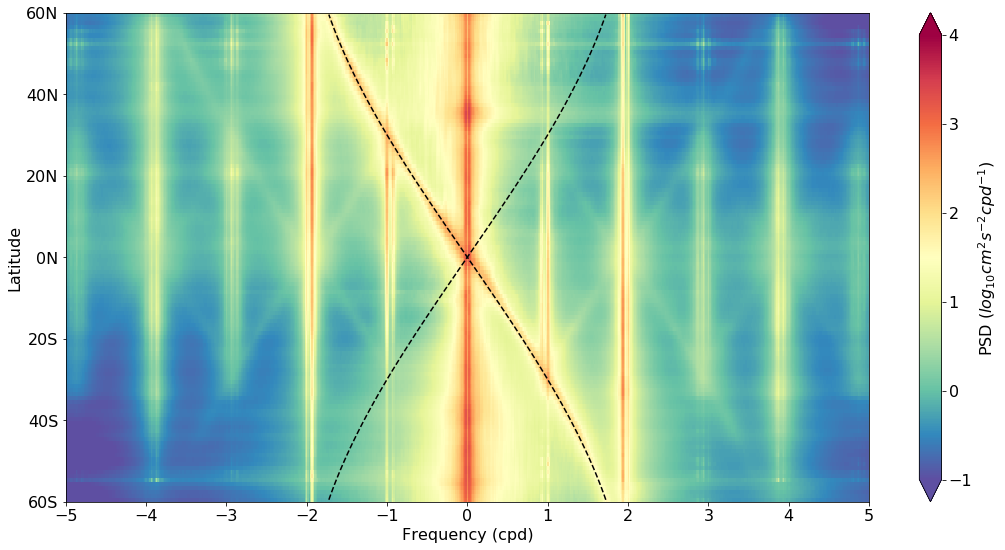

In [12]:
plt.figure(figsize=(18,9))
ax = plt.subplot(1,1,1)

E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
cax = np.log10(E/8.64).plot.pcolormesh(ax=ax, vmin=-1, vmax=4., x='freq_cpd', y='lat', cmap = 'Spectral_r', add_colorbar = False)

# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=16)
            
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylabel('Latitude',fontsize=16)
ax.set_xlabel('Frequency (cpd)',fontsize=16)
ax.tick_params(labelsize=16)

# add coriolis frequency
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
ax.plot(f*86400./2./np.pi,f.lat,'k--')
ax.plot(-f*86400./2./np.pi,f.lat,'k--')

In [9]:
cluster.scheduler.close()

<Future finished result=None>